# Experimentation with there CERES model with a covariate for gene copy number

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano

In [3]:
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as sampling
from src.models.crc_ceres_mimic_one import CrcCeresMimicOne
from src.plot.color_pal import SeabornColor

In [5]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1243
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [54]:
data = achelp.read_achilles_data(
    Path("..", "..", "modeling_data", "depmap_CRC_data_subsample.csv")
)
data.head()

sgrna                    replicate_id       lfc pdna_batch  \
0  CCACCCACAGACGCTCAGCA    ls513-311cas9_repa_p6_batch2  0.029491          2   
1  CCACCCACAGACGCTCAGCA    ls513-311cas9_repb_p6_batch2  0.426017          2   
2  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep a p5_batch3  0.008626          3   
3  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep b p5_batch3  0.280821          3   
4  CCACCCACAGACGCTCAGCA  c2bbe1-311cas9 rep c p5_batch3  0.239815          3   

   passes_qc   depmap_id primary_or_metastasis     lineage  \
0       True  ACH-000007               Primary  colorectal   
1       True  ACH-000007               Primary  colorectal   
2       True  ACH-000009               Primary  colorectal   
3       True  ACH-000009               Primary  colorectal   
4       True  ACH-000009               Primary  colorectal   

             lineage_subtype kras_mutation  ... any_deleterious  \
0  colorectal_adenocarcinoma          G12D  ...           False   
1  colorectal_adenocarcinoma          G12D  ...           False   
2  colorectal_adenocarcinoma            WT  ...           False   
3  colorectal_adenocarcinoma            WT  ...           False   
4  colorectal_adenocarcinoma            WT  ...           False   

   variant_classification is_deleterious is_tcga_hotspot  is_cosmic_hotspot  \
0                     NaN            NaN             NaN                NaN   
1                     NaN            NaN             NaN                NaN   
2                     NaN            NaN             NaN                NaN   
3                     NaN            NaN             NaN                NaN   
4                     NaN            NaN             NaN                NaN   

   mutated_at_guide_location  rna_expr   log2_cn  z_log2_cn  is_mutated  
0                      False  1.480265  1.861144   1.386218           0  
1                      False  1.480265  1.861144   1.386218           0  
2                      False  0.695994  1.375470  -0.234394           0  
3                      False  0.695994  1.375470  -0.234394           0  
4                      False  0.695994  1.375470  -0.234394           0  

[5 rows x 30 columns]

## EDA of the gene CN

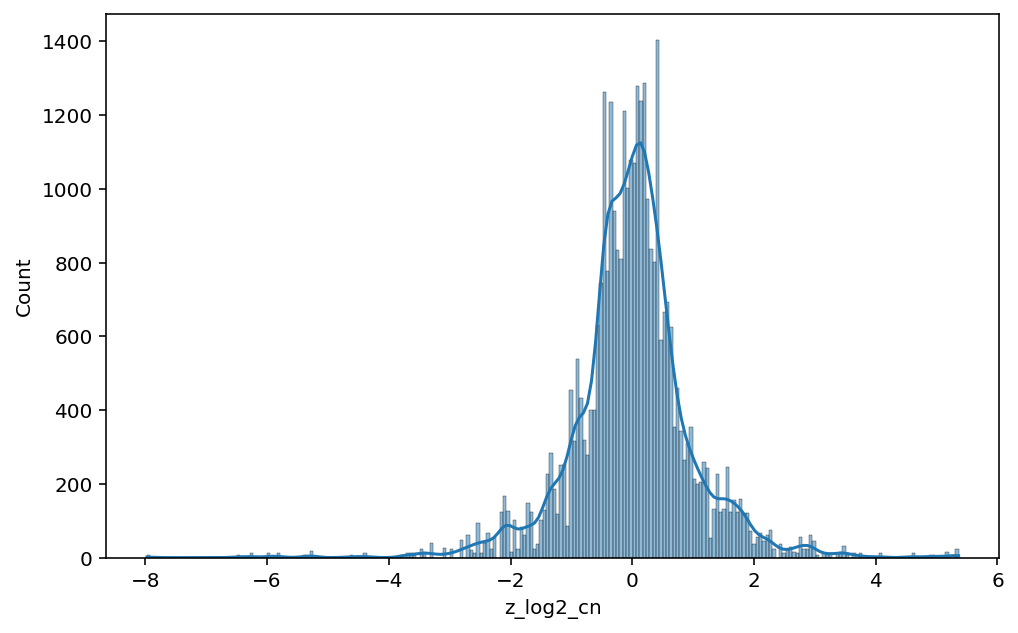

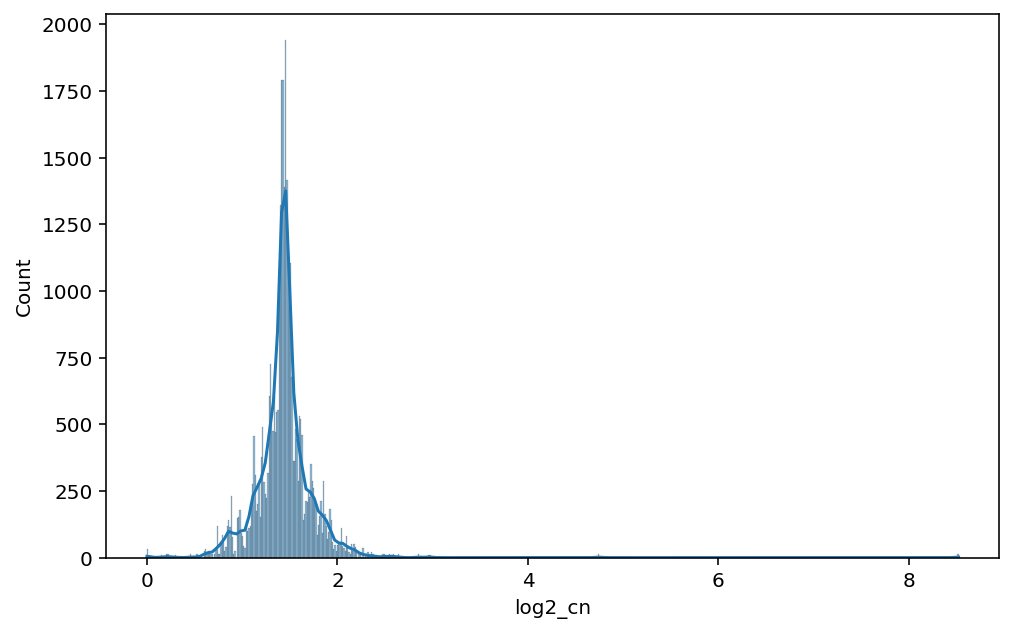

In [42]:
for col in ["z_log2_cn", "log2_cn"]:
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(data=data, x=col, ax=ax, kde=True)
    plt.show()

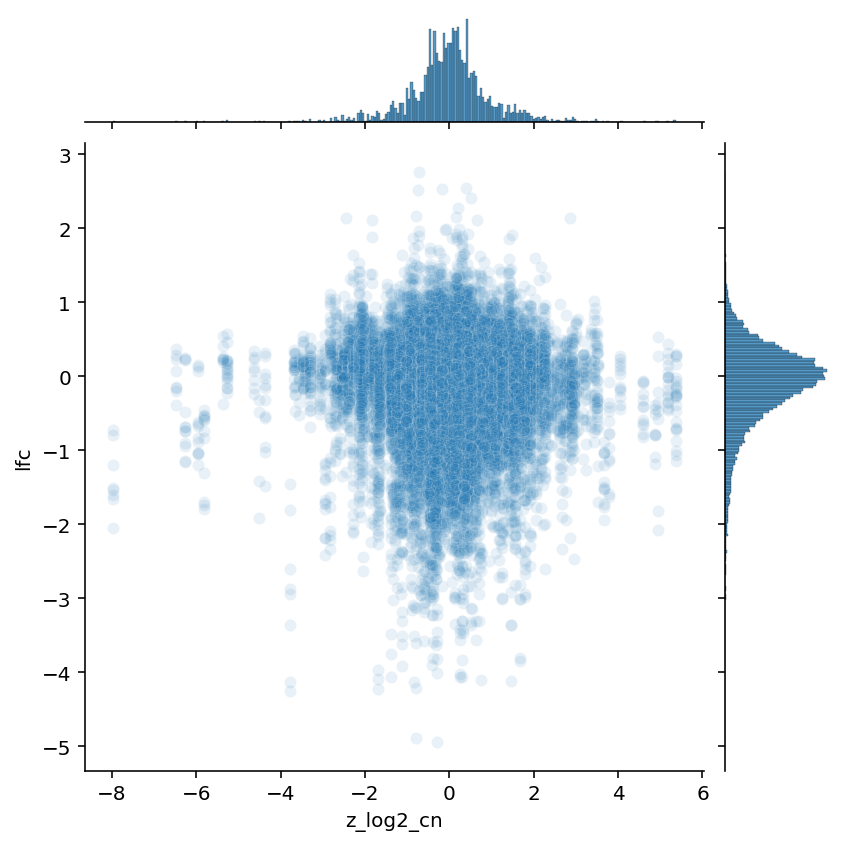

In [43]:
sns.jointplot(data=data, x="z_log2_cn", y="lfc", alpha=0.1);

In [55]:
missing_cn_frac = (
    data.assign(missing_cn=lambda d: d.z_log2_cn.isna())
    .groupby(["hugo_symbol"])
    .mean()
    .reset_index(drop=False)
)

missing_cn_frac.query("missing_cn > 0.0")

hugo_symbol       lfc  passes_qc  n_alignments    chrom_pos  segment_mean  \
85       SSX4B -0.691129        1.0          4.25  48410882.75      0.672434   

    segment_cn  log2_gene_cn_p1  gene_cn  n_muts  any_deleterious  \
85    1.655305              NaN      NaN     0.0              0.0   

    mutated_at_guide_location  rna_expr  log2_cn  z_log2_cn  is_mutated  \
85                        0.0  0.010955      NaN        NaN         0.0   

    missing_cn  
85         1.0

In [58]:
# Remove samples with NA for copy number.
data = (
    data[~data.z_log2_cn.isna()]
    .reset_index(drop=True)
    .pipe(achelp.set_achilles_categorical_columns)
)

## Model Experimentation

### Model design

In [63]:
lfc_data = data.lfc.values
copynumber_data = data.z_log2_cn.values
total_size = len(data.lfc.values)

indices = achelp.common_indices(data)

sgrna_idx = indices.sgrna_idx
sgrna_to_gene_idx = indices.sgrna_to_gene_idx
gene_idx = indices.gene_idx
cellline_idx = indices.cellline_idx
batch_idx = indices.batch_idx

n_sgrnas = dphelp.nunique(sgrna_idx)
n_genes = dphelp.nunique(gene_idx)
n_celllines = dphelp.nunique(cellline_idx)
n_batches = dphelp.nunique(batch_idx)

sgrna_idx_shared = theano.shared(sgrna_idx)
sgrna_to_gene_idx_shared = theano.shared(sgrna_to_gene_idx)
gene_idx_shared = theano.shared(gene_idx)
cellline_idx_shared = theano.shared(cellline_idx)
batch_idx_shared = theano.shared(batch_idx)
lfc_shared = theano.shared(lfc_data)
copynumber_shared = theano.shared(copynumber_data)

with pm.Model() as model:

    # Hyper-priors
    σ_a = pm.HalfNormal("σ_a", np.array([0.1, 0.5]), shape=2)
    a = pm.Exponential("a", σ_a, shape=(n_genes, 2))

    μ_h = pm.Normal("μ_h", np.mean(lfc_data), 1)
    σ_h = pm.HalfNormal("σ_h", 1)

    μ_d = pm.Normal("μ_d", 0, 0.2)
    σ_d = pm.HalfNormal("σ_d", 0.5)

    μ_β = pm.Normal("μ_β", 0, 0.1)
    σ_β = pm.HalfNormal("σ_β", 0.5)

    μ_η = pm.Normal("μ_η", 0, 0.1)
    σ_η = pm.HalfNormal("σ_η", 0.5)

    # Main parameter priors
    q = pm.Beta(
        "q",
        alpha=a[sgrna_to_gene_idx_shared, 0],
        beta=a[sgrna_to_gene_idx_shared, 1],
        shape=n_sgrnas,
    )
    h = pm.Normal("h", μ_h, σ_h, shape=n_genes)
    d = pm.Normal("d", μ_d, σ_d, shape=(n_genes, n_celllines))
    β = pm.Normal("β", μ_β, σ_β, shape=n_celllines)
    η = pm.Normal("η", μ_η, σ_η, shape=n_batches)

    μ = pm.Deterministic(
        "μ",
        q[sgrna_idx_shared]
        * (h[gene_idx_shared] + d[gene_idx_shared, cellline_idx_shared])
        + β[cellline_idx_shared] * copynumber_shared
        + η[batch_idx_shared],
    )
    σ = pm.HalfNormal("σ", 2)

    # Likelihood
    lfc = pm.Normal("lfc", μ, σ, observed=lfc_shared, total_size=total_size)

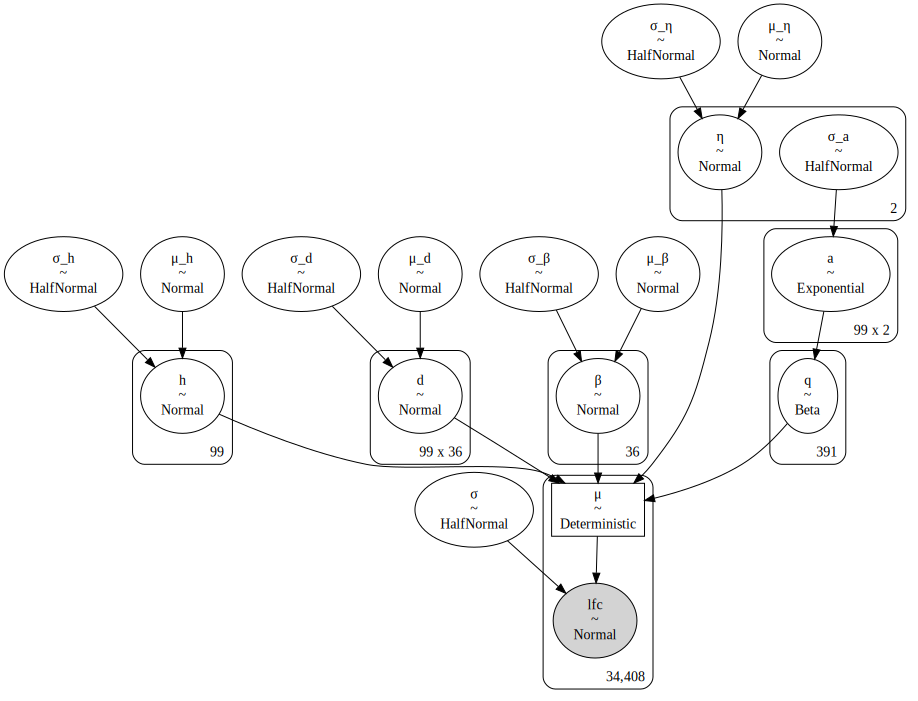

In [64]:
pm.model_to_graphviz(model)

In [65]:
with model:
    prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

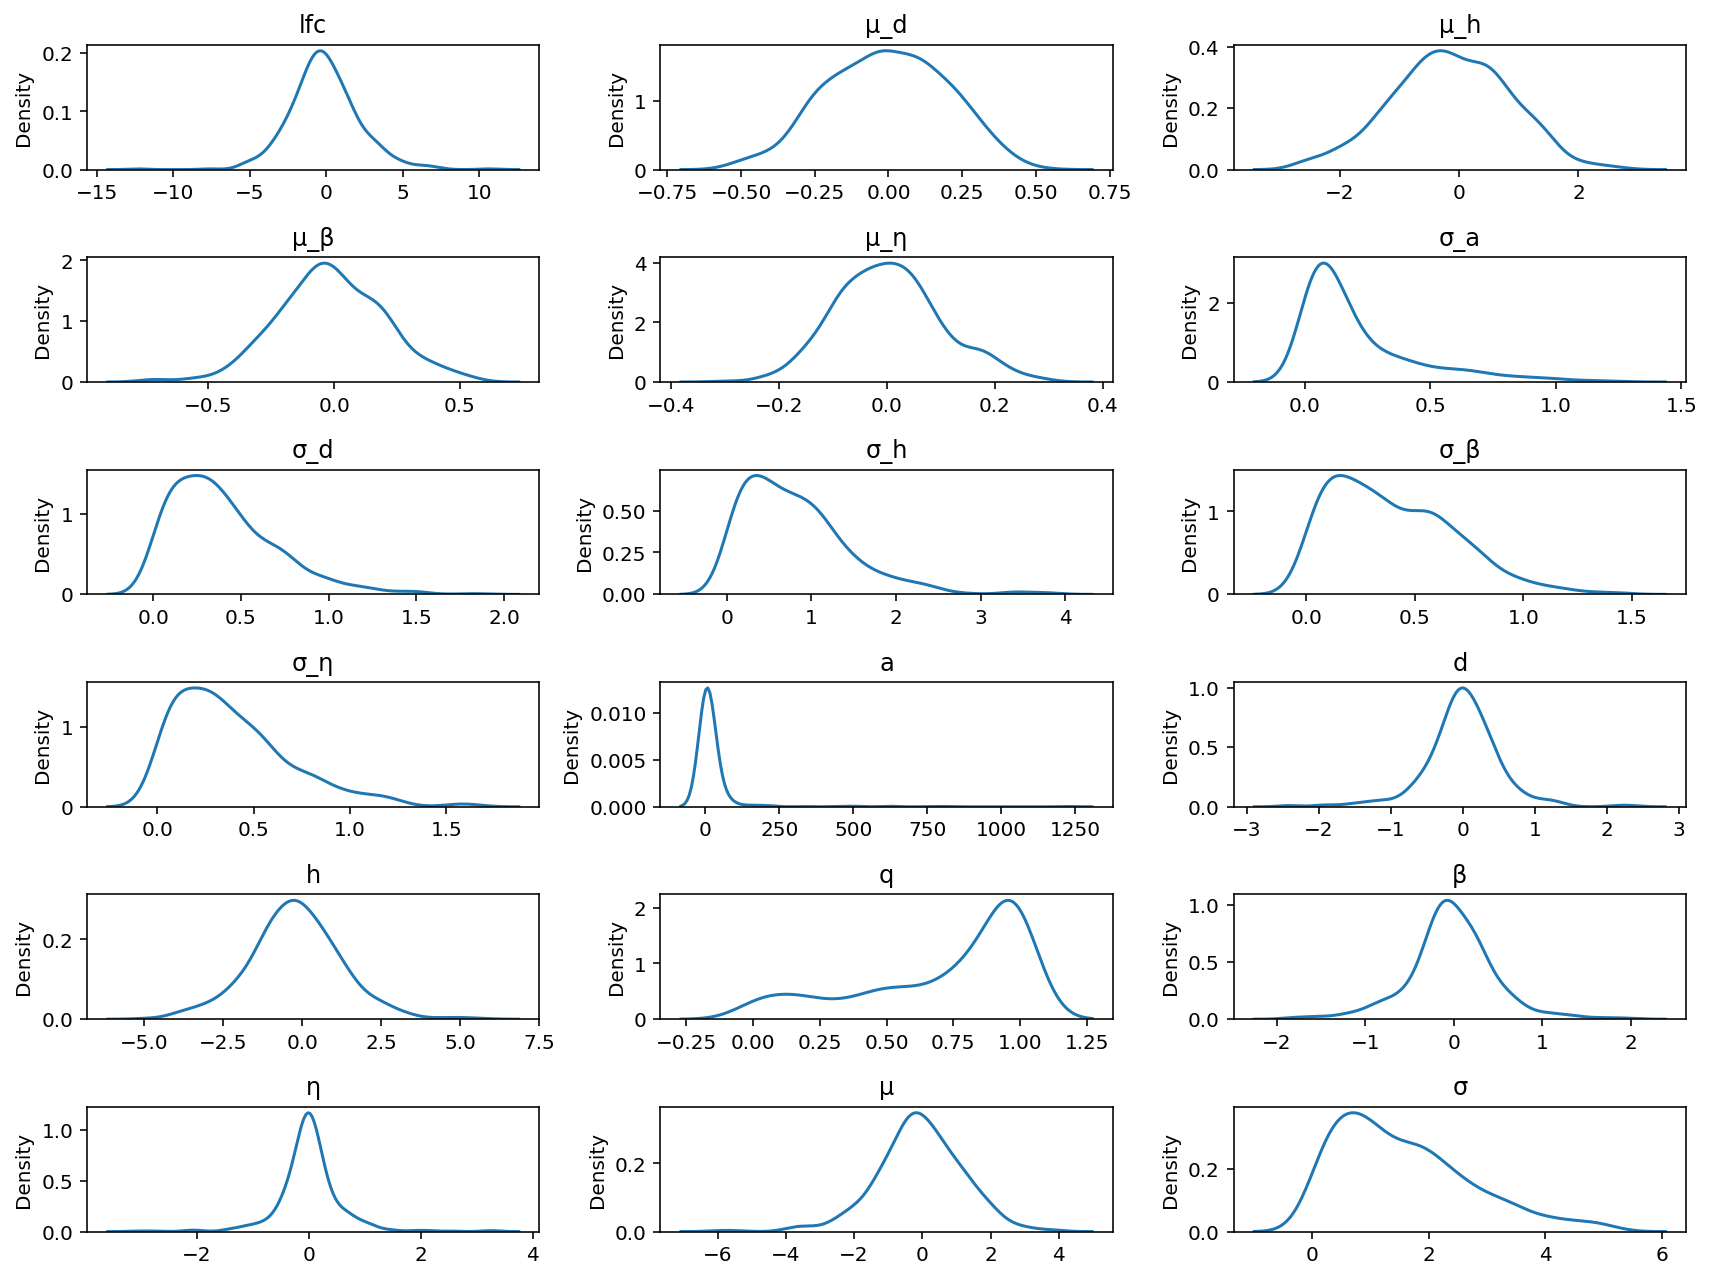

In [66]:
pmanal.plot_all_priors(prior_pred, subplots=(6, 3), figsize=(12, 9), samples=500);

## ADVI

In [68]:
batch_size = 1000

sgnra_idx_batch = pm.Minibatch(sgrna_idx, batch_size=batch_size)
gene_idx_batch = pm.Minibatch(gene_idx, batch_size=batch_size)
cellline_idx_batch = pm.Minibatch(cellline_idx, batch_size=batch_size)
batch_idx_batch = pm.Minibatch(batch_idx, batch_size=batch_size)
copynumpy_batch = pm.Minibatch(data.z_log2_cn.values, batch_size=batch_size)
lfc_data_batch = pm.Minibatch(data.lfc.values, batch_size=batch_size)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [69]:
meanfield = sampling.pymc3_advi_approximation_procedure(
    model=model,
    method="advi",
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            gene_idx_shared: gene_idx_batch,
            cellline_idx_shared: cellline_idx_batch,
            batch_idx_shared: batch_idx_batch,
            copynumber_shared: copynumpy_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Convergence achieved at 51000
Interrupted at 50,999 [50%]: Average Loss = 843.07


In [70]:
az_model = sampling.convert_samples_to_arviz(model, meanfield)

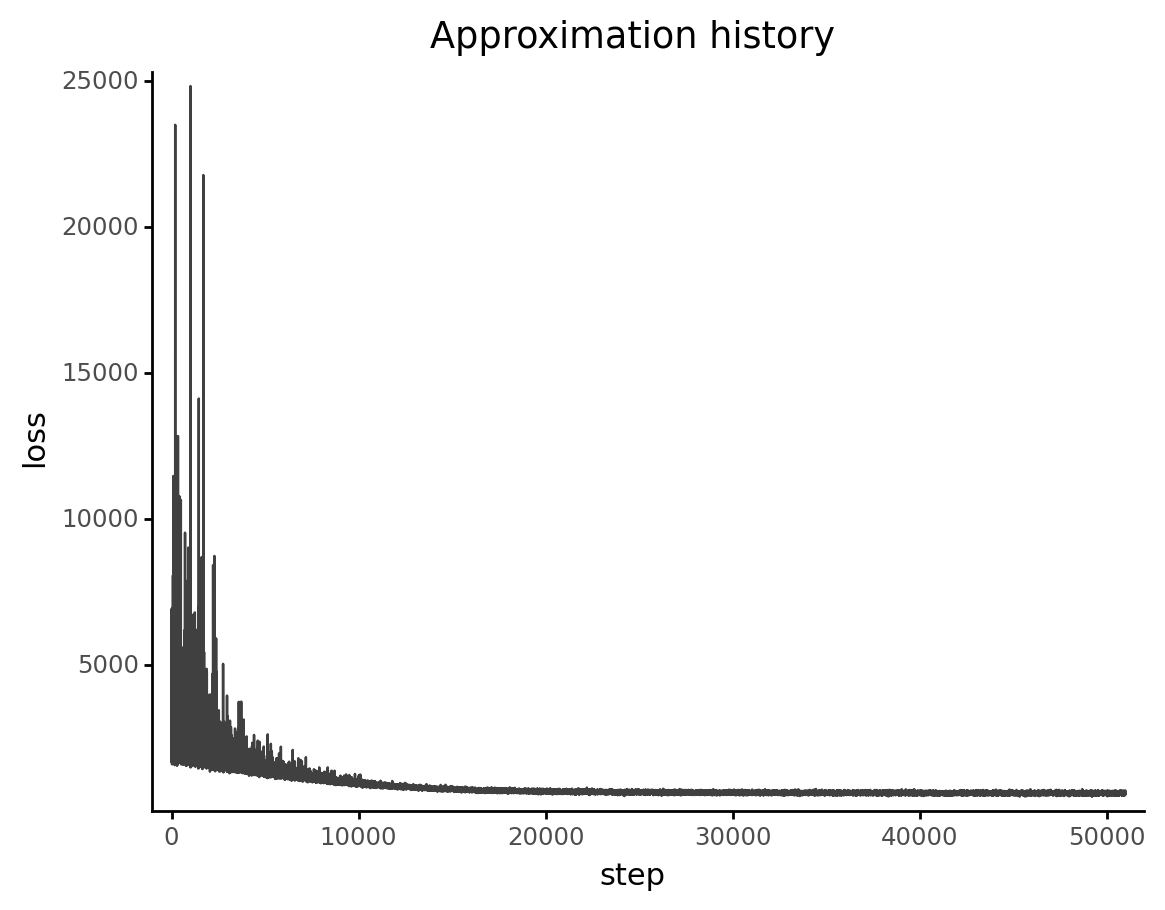

<ggplot: (366973486)>

In [71]:
pmanal.plot_vi_hist(meanfield.approximation)

In [72]:
def plot_az_summary(df: pd.DataFrame, x="index", aes_kwargs={}) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x=x))
        + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5)
        + gg.geom_linerange(
            gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", **aes_kwargs), size=0.2
        )
        + gg.geom_point(gg.aes(y="mean", **aes_kwargs), size=0.5)
        + gg.theme(axis_text_x=gg.element_text(angle=90, size=6))
        + gg.labs(x="model parameter", y="posterior")
    )

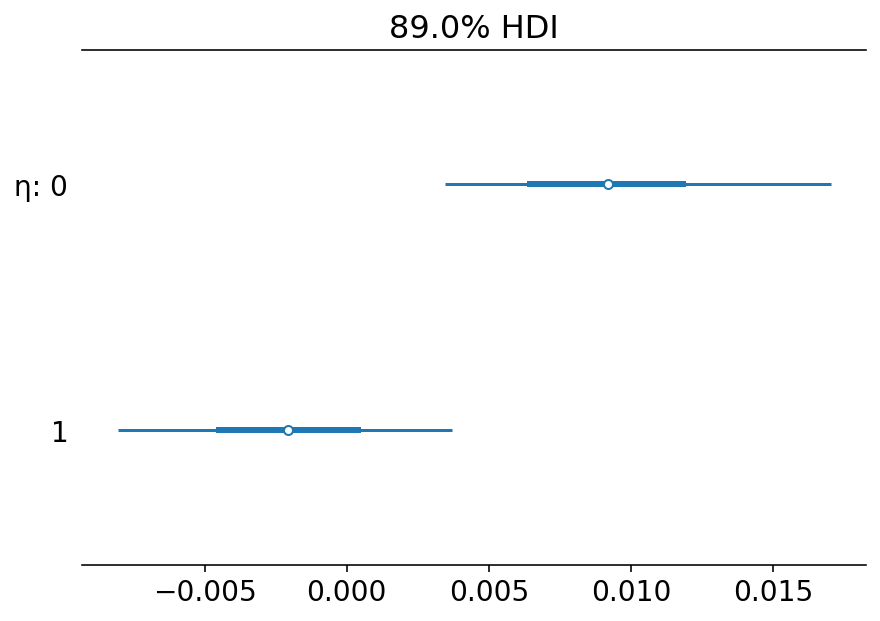

In [74]:
az.plot_forest(az_model, var_names="η", hdi_prob=0.89);

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


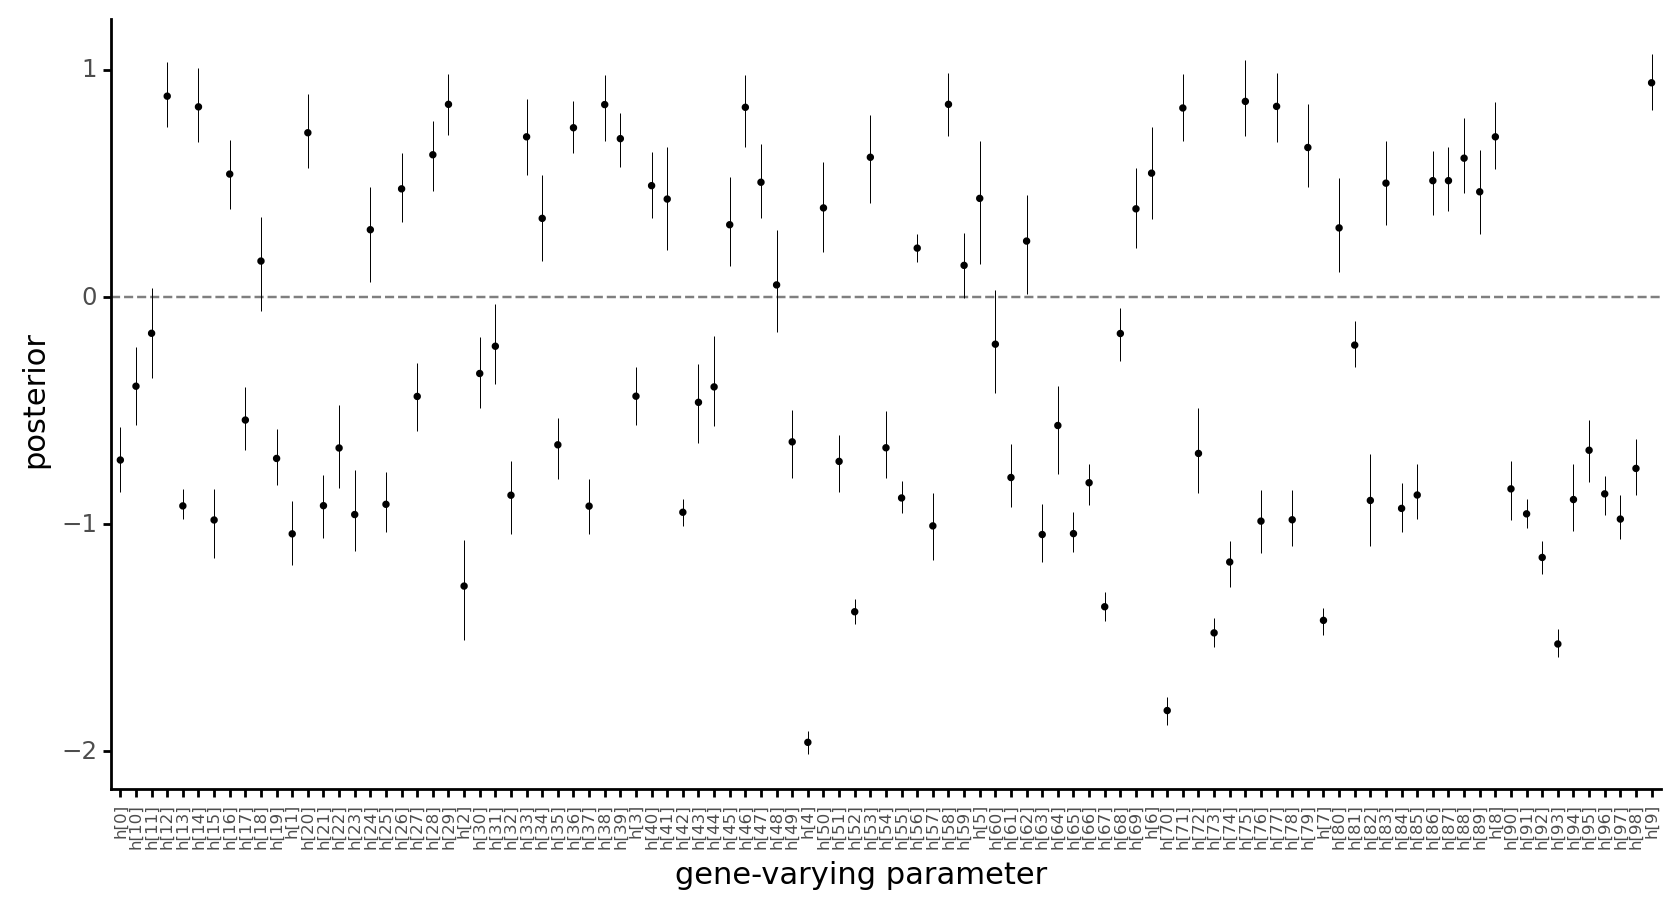

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


<ggplot: (365105628)>


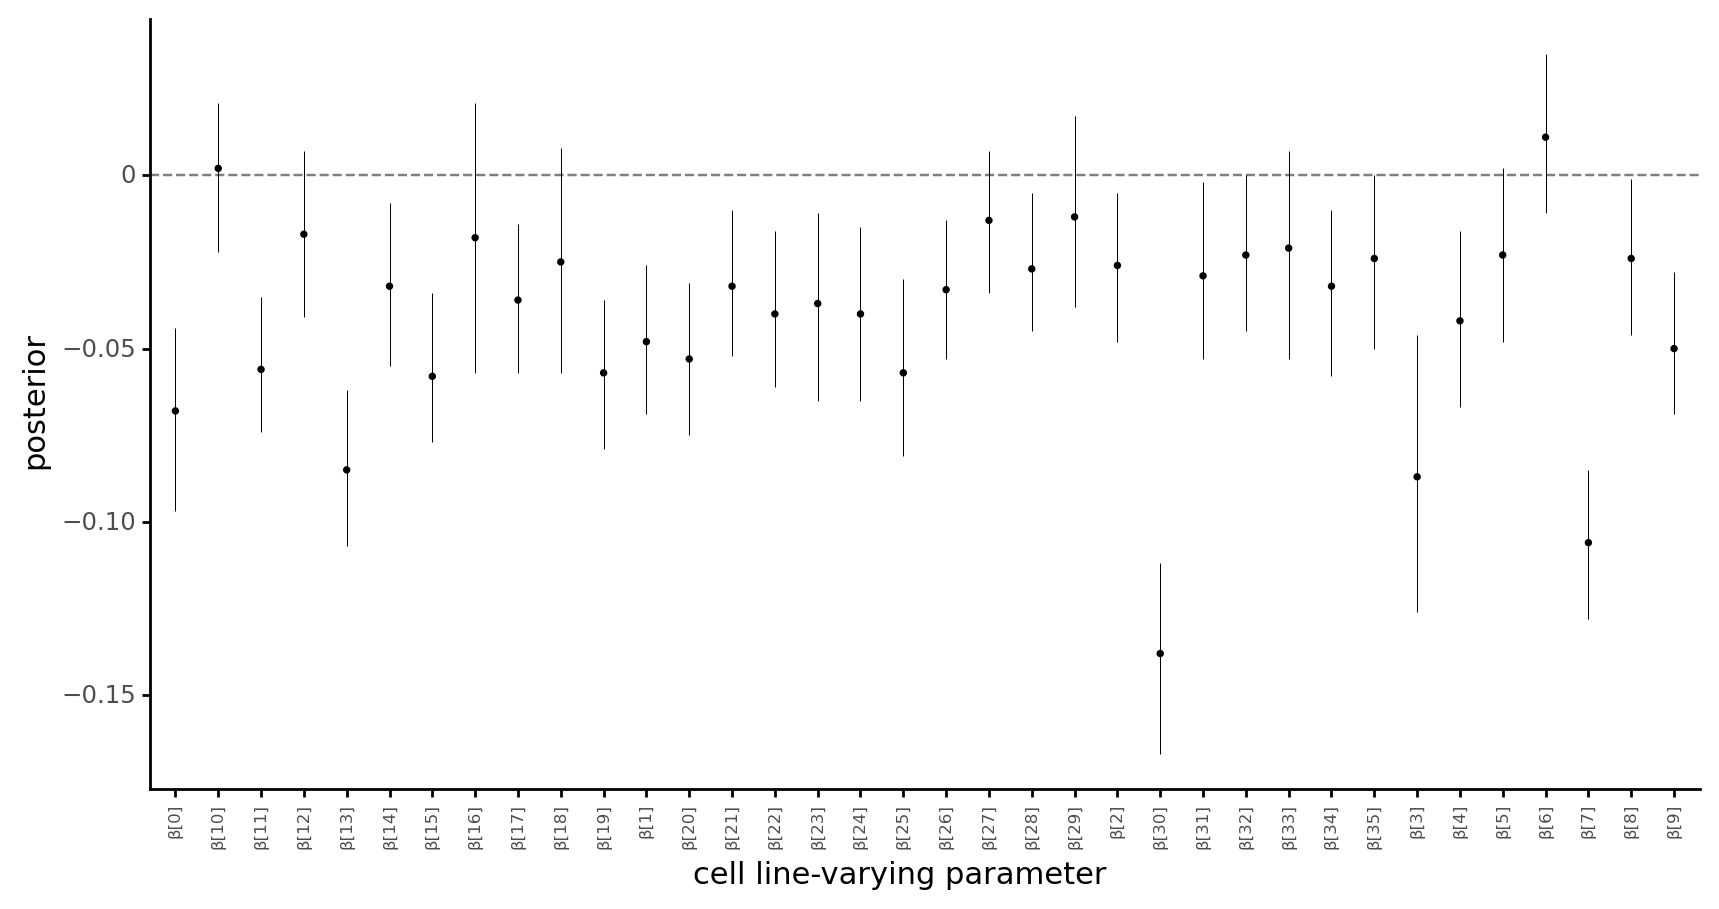

<ggplot: (368521388)>


In [78]:
for param, x_lab in zip(["h", "β"], ["gene", "cell line"]):

    gene_posteriors = az.summary(
        az_model,
        var_names=param,
        hdi_prob=0.89,
    )

    p = (
        plot_az_summary(gene_posteriors.reset_index(drop=False))
        + gg.theme(figure_size=(10, 5))
        + gg.labs(x=f"{x_lab}-varying parameter")
    )
    print(p)

In [79]:
genes = data.hugo_symbol.cat.categories.values

sgrna_activity_params = pmanal.extract_matrix_variable_indices(
    az.summary(
        az_model,
        var_names="a",
        hdi_prob=0.89,
    ).reset_index(drop=False),
    col="index",
    idx1=genes,
    idx2=np.array(["alpha", "beta"]),
    idx1name="hugo_symbol",
    idx2name="beta_param",
)

sgrna_activity_params.head()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


index   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0  a[0,0]  1.521  0.568     0.741      2.352      0.017    0.012    1037.0   
1  a[0,1]  5.643  2.255     2.114      8.582      0.073    0.052     965.0   
2  a[1,0]  1.199  0.448     0.563      1.828      0.015    0.011     901.0   
3  a[1,1]  4.665  2.111     1.808      7.279      0.066    0.047     968.0   
4  a[2,0]  2.499  1.714     0.494      4.376      0.058    0.041     971.0   

   ess_tail  r_hat hugo_symbol beta_param  
0     848.0    NaN    ADAMTS13      alpha  
1    1017.0    NaN    ADAMTS13       beta  
2     917.0    NaN      ADGRA3      alpha  
3     977.0    NaN      ADGRA3       beta  
4     880.0    NaN       AKR7L      alpha

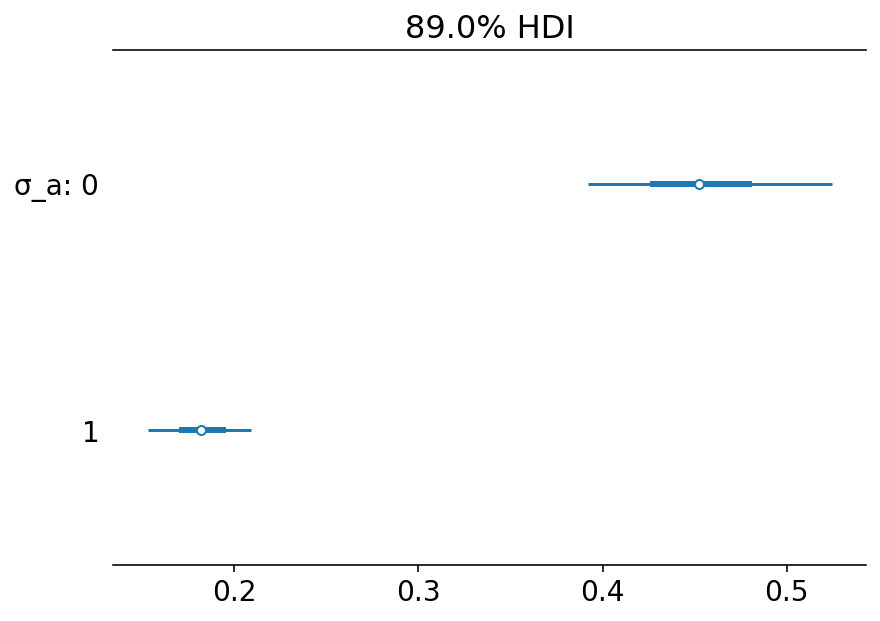

In [80]:
az.plot_forest(az_model, var_names="σ_a", hdi_prob=0.89);

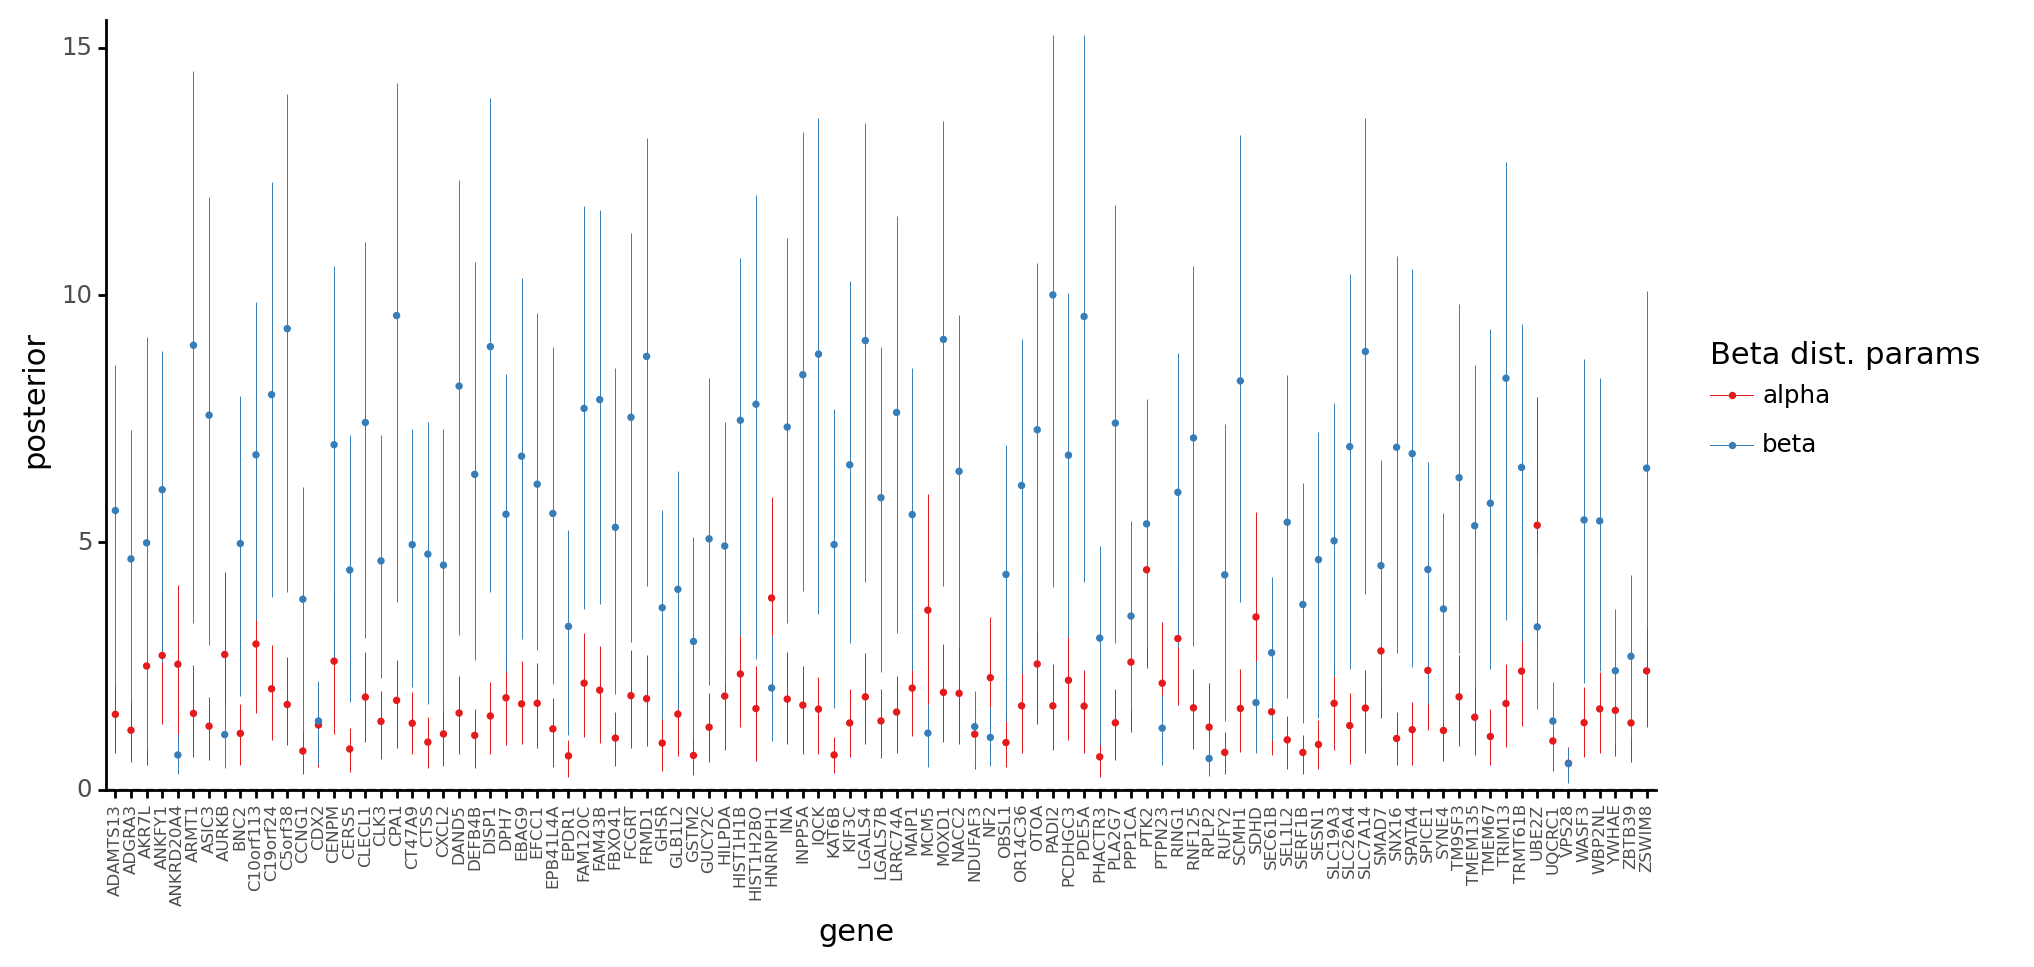

<ggplot: (366491941)>

In [81]:
(
    plot_az_summary(
        sgrna_activity_params, x="hugo_symbol", aes_kwargs={"color": "beta_param"}
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(10, 5))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(color="Beta dist. params", x="gene")
)

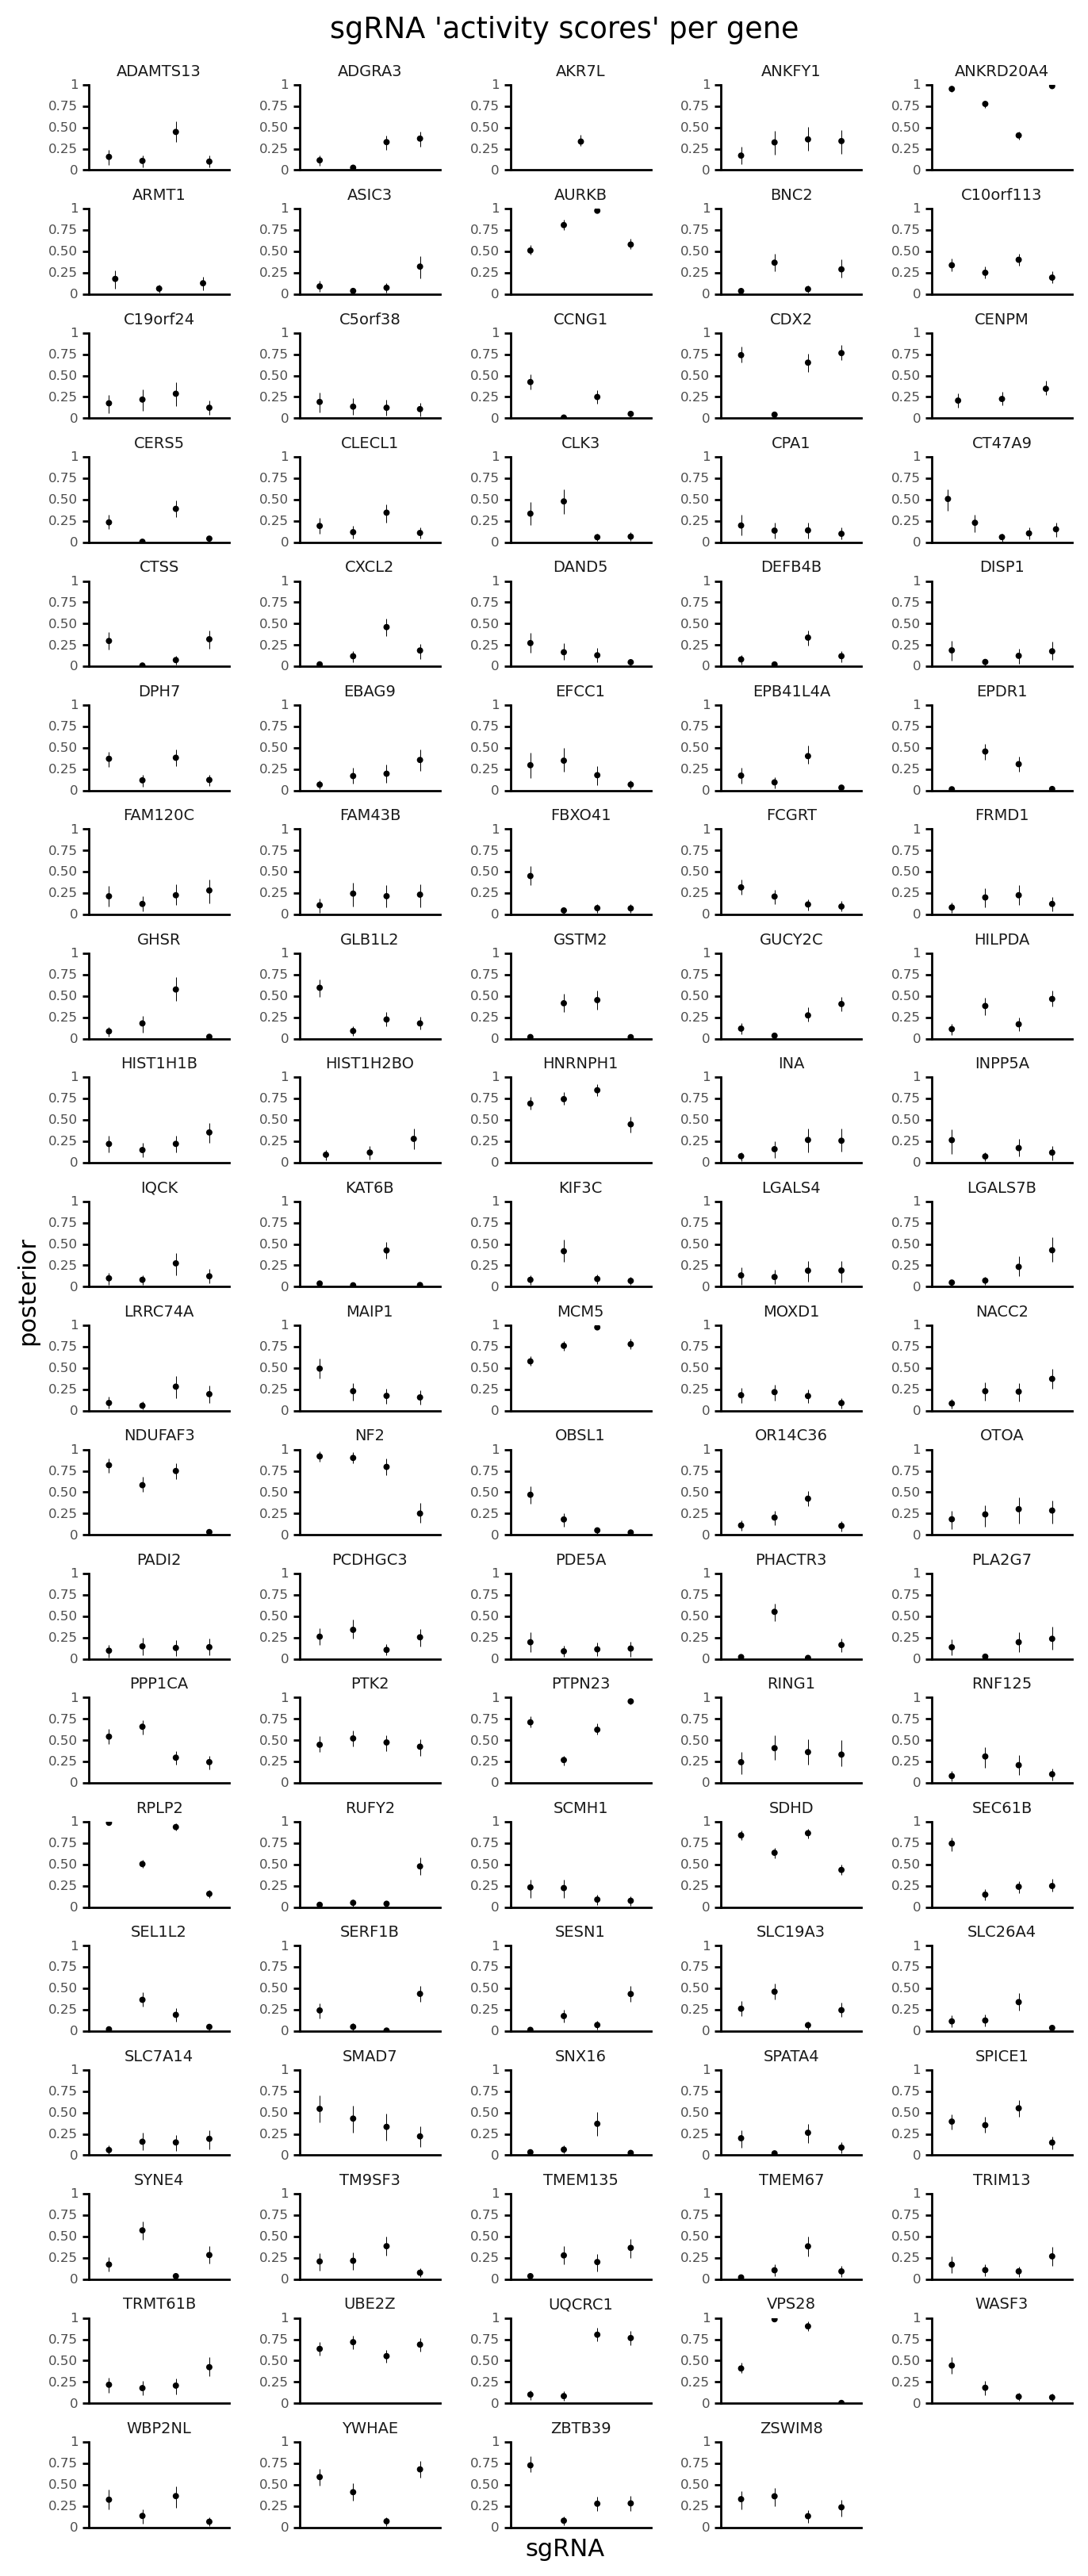

<ggplot: (358942028)>

In [82]:
sgrna_activity_post = (
    az.summary(
        az_model,
        var_names="q",
        hdi_prob=0.89,
        kind="stats",
    )
    .reset_index(drop=False)
    .assign(sgrna=data.sgrna.cat.categories.values)
    .merge(indices.sgrna_to_gene_map)
)

(
    gg.ggplot(sgrna_activity_post, gg.aes(x="index"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=5)
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2)
    + gg.geom_point(gg.aes(y="mean"), size=0.6)
    + gg.scale_y_continuous(limits=(0, 1), expand=(0, 0))
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 20),
        subplots_adjust={"wspace": 0.5},
        axis_text_y=gg.element_text(size=6),
        axis_ticks_major_x=gg.element_blank(),
        strip_text=gg.element_text(size=7),
    )
    + gg.labs(x="sgRNA", y="posterior", title="sgRNA 'activity scores' per gene")
)

In [83]:
gene_cells_post = az.summary(
    az_model, var_names="d", hdi_prob=0.89, kind="stats"
).reset_index(drop=False)
gene_cells_post = pmanal.extract_matrix_variable_indices(
    gene_cells_post,
    col="index",
    idx1=data.hugo_symbol.cat.categories.values,
    idx2=data.depmap_id.cat.categories.values,
    idx1name="hugo_symbol",
    idx2name="depmap_id",
)
gene_cells_post.head()

index   mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol   depmap_id
0  d[0,0]  0.367  0.417    -0.352      0.950    ADAMTS13  ACH-000007
1  d[0,1] -0.020  0.380    -0.606      0.576    ADAMTS13  ACH-000009
2  d[0,2]  0.307  0.384    -0.284      0.954    ADAMTS13  ACH-000202
3  d[0,3] -0.141  0.455    -0.864      0.604    ADAMTS13  ACH-000249
4  d[0,4]  0.133  0.404    -0.492      0.795    ADAMTS13  ACH-000253

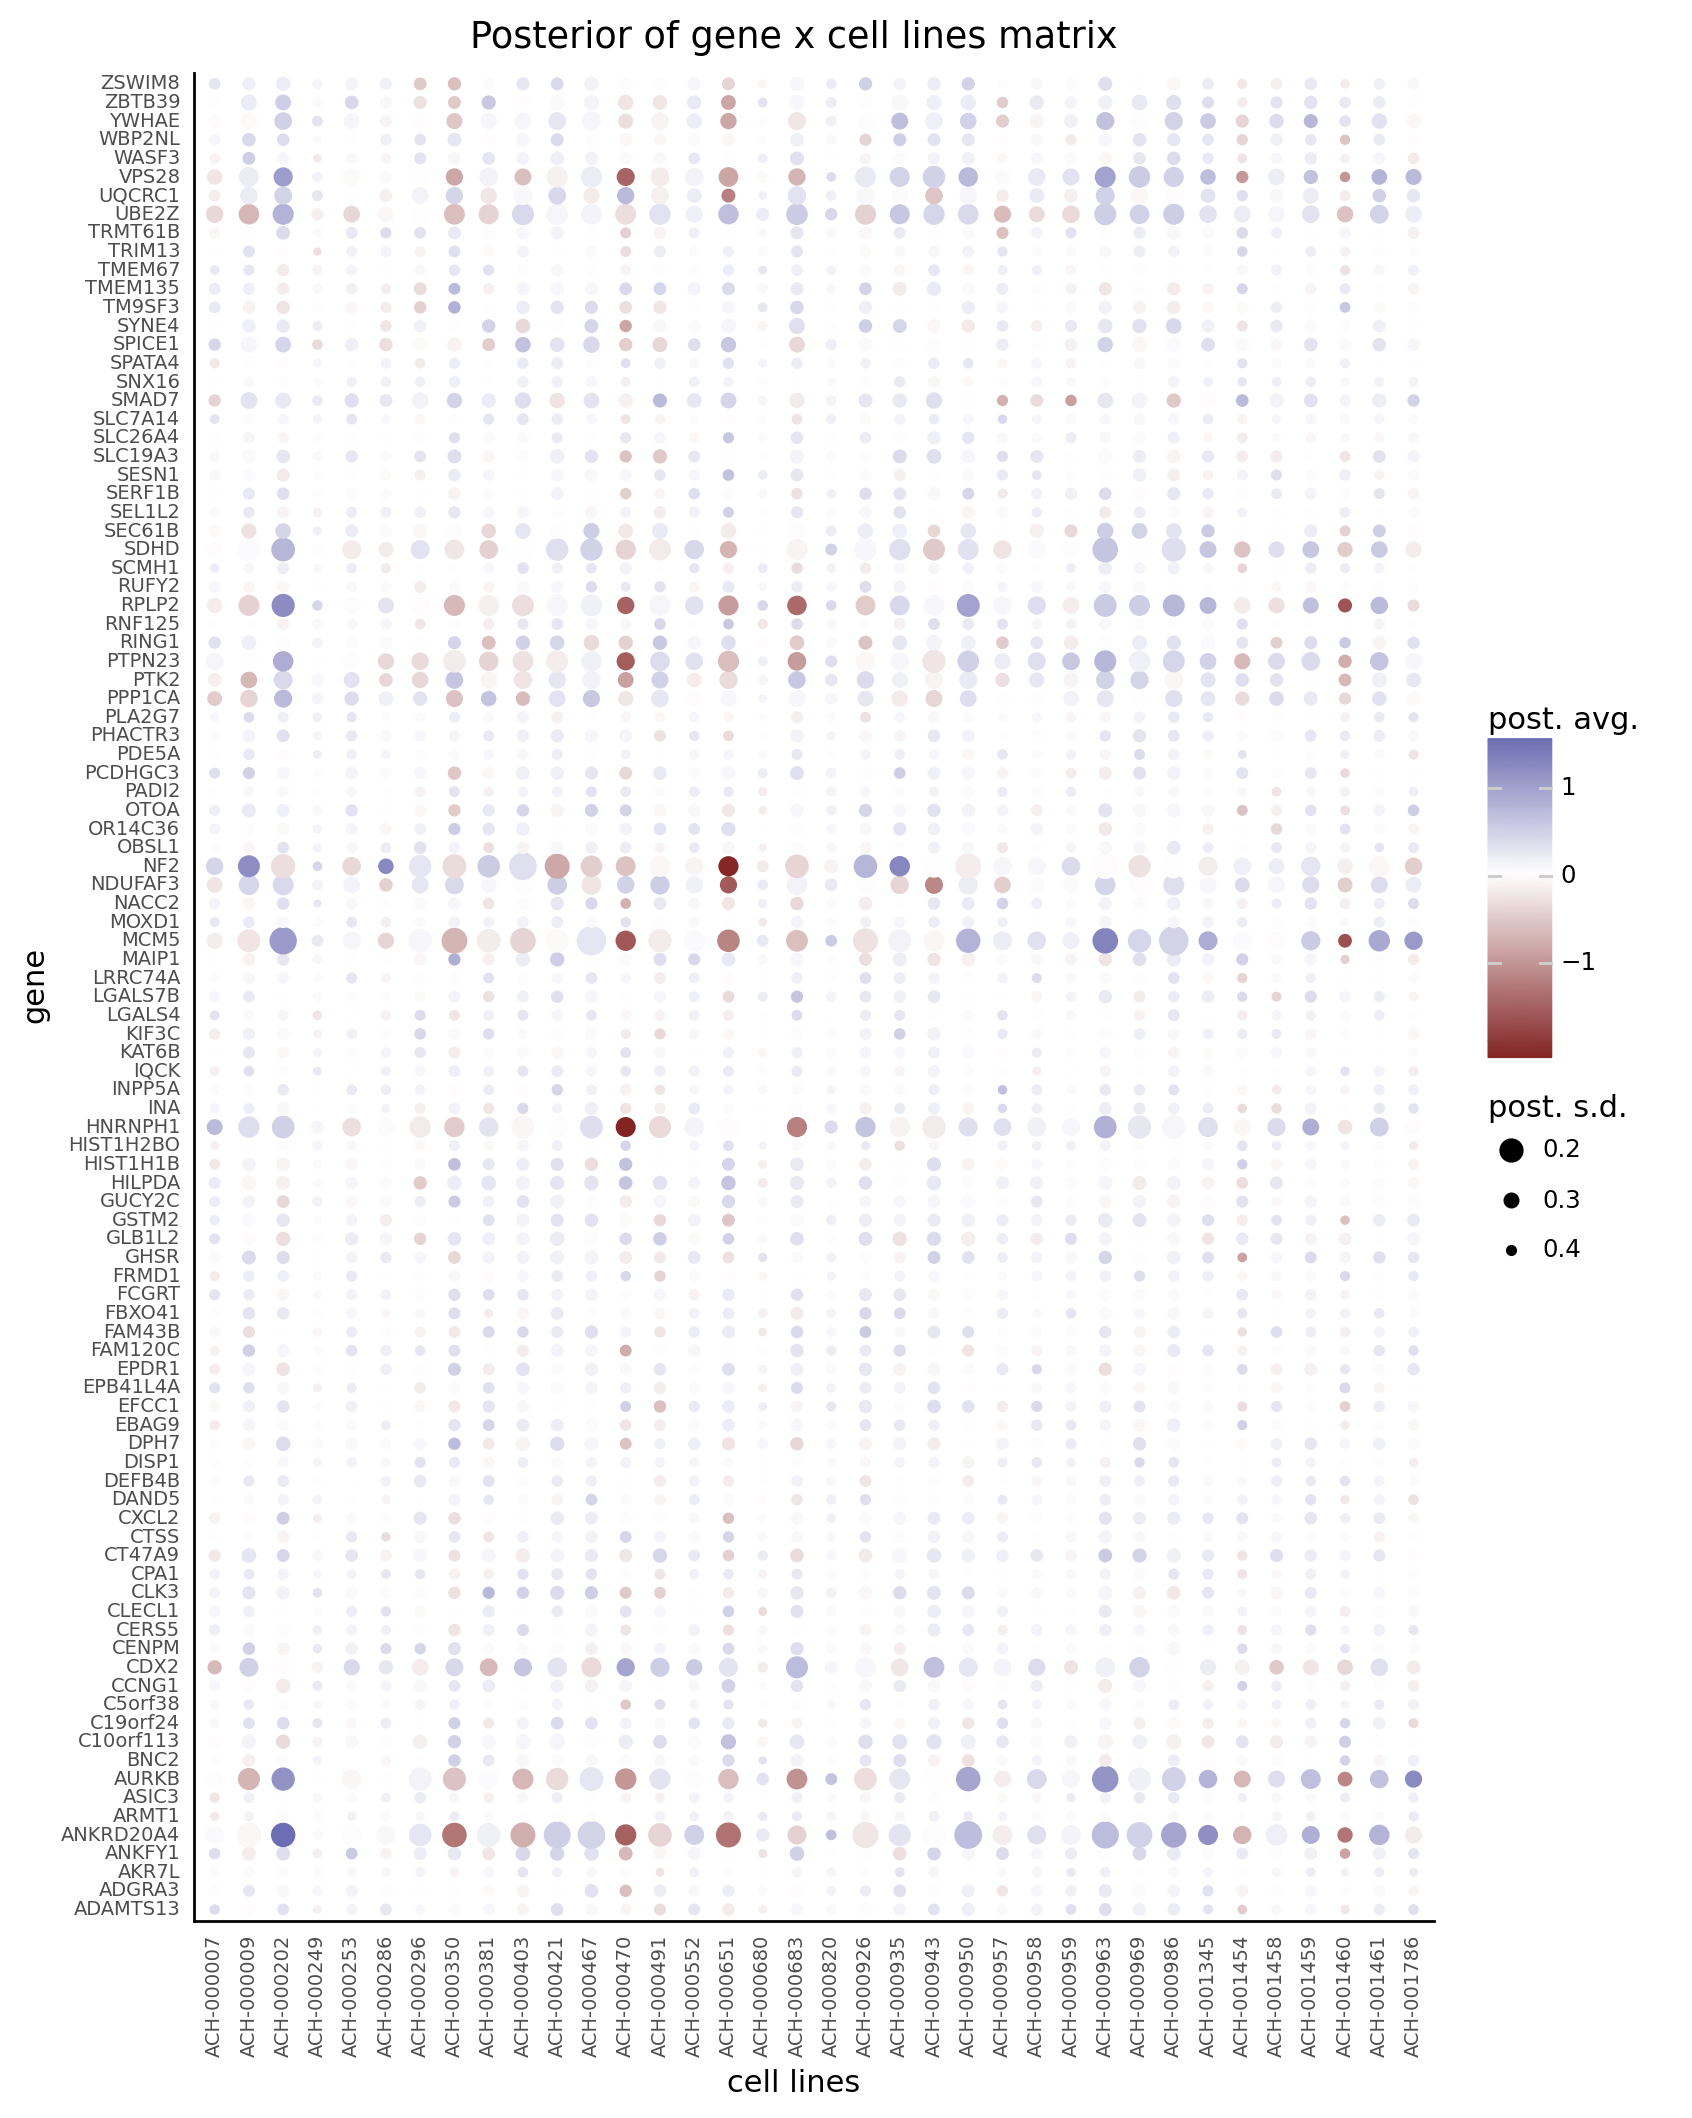

<ggplot: (365335143)>

In [84]:
(
    gg.ggplot(gene_cells_post, gg.aes(x="depmap_id", y="hugo_symbol"))
    + gg.geom_point(gg.aes(size="sd", color="mean"))
    + gg.scale_color_gradient2()
    + gg.scale_size_continuous(range=(5, 0.5))
    + gg.theme(
        figure_size=(8, 12),
        axis_text_x=gg.element_text(angle=90, size=7),
        axis_text_y=gg.element_text(size=7),
        axis_ticks=gg.element_blank(),
    )
    + gg.labs(
        x="cell lines",
        y="gene",
        color="post. avg.",
        size="post. s.d.",
        title="Posterior of gene x cell lines matrix",
    )
)

In [86]:
model_ppc = pmanal.summarize_posterior_predictions(
    meanfield.posterior_predictive["lfc"],
    merge_with=data[
        ["lfc", "hugo_symbol", "depmap_id", "sgrna", "pdna_batch", "gene_cn"]
    ],
).assign(hdi_range=lambda d: np.abs(d.pred_hdi_high - d.pred_hdi_low))
model_ppc["error"] = model_ppc.lfc - model_ppc.pred_mean
model_ppc.head()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


pred_mean  pred_hdi_low  pred_hdi_high       lfc hugo_symbol   depmap_id  \
0  -0.118043     -0.797250       0.571868  0.029491    ADAMTS13  ACH-000007   
1  -0.133617     -0.772268       0.526572  0.426017    ADAMTS13  ACH-000007   
2  -0.111257     -0.751671       0.560312  0.008626    ADAMTS13  ACH-000009   
3  -0.115983     -0.818436       0.595282  0.280821    ADAMTS13  ACH-000009   
4  -0.090341     -0.802413       0.581360  0.239815    ADAMTS13  ACH-000009   

                  sgrna pdna_batch   gene_cn  hdi_range     error  
0  CCACCCACAGACGCTCAGCA          2  2.632957   1.369118  0.147534  
1  CCACCCACAGACGCTCAGCA          2  2.632957   1.298840  0.559634  
2  CCACCCACAGACGCTCAGCA          3  1.594524   1.311983  0.119883  
3  CCACCCACAGACGCTCAGCA          3  1.594524   1.413718  0.396804  
4  CCACCCACAGACGCTCAGCA          3  1.594524   1.383773  0.330156

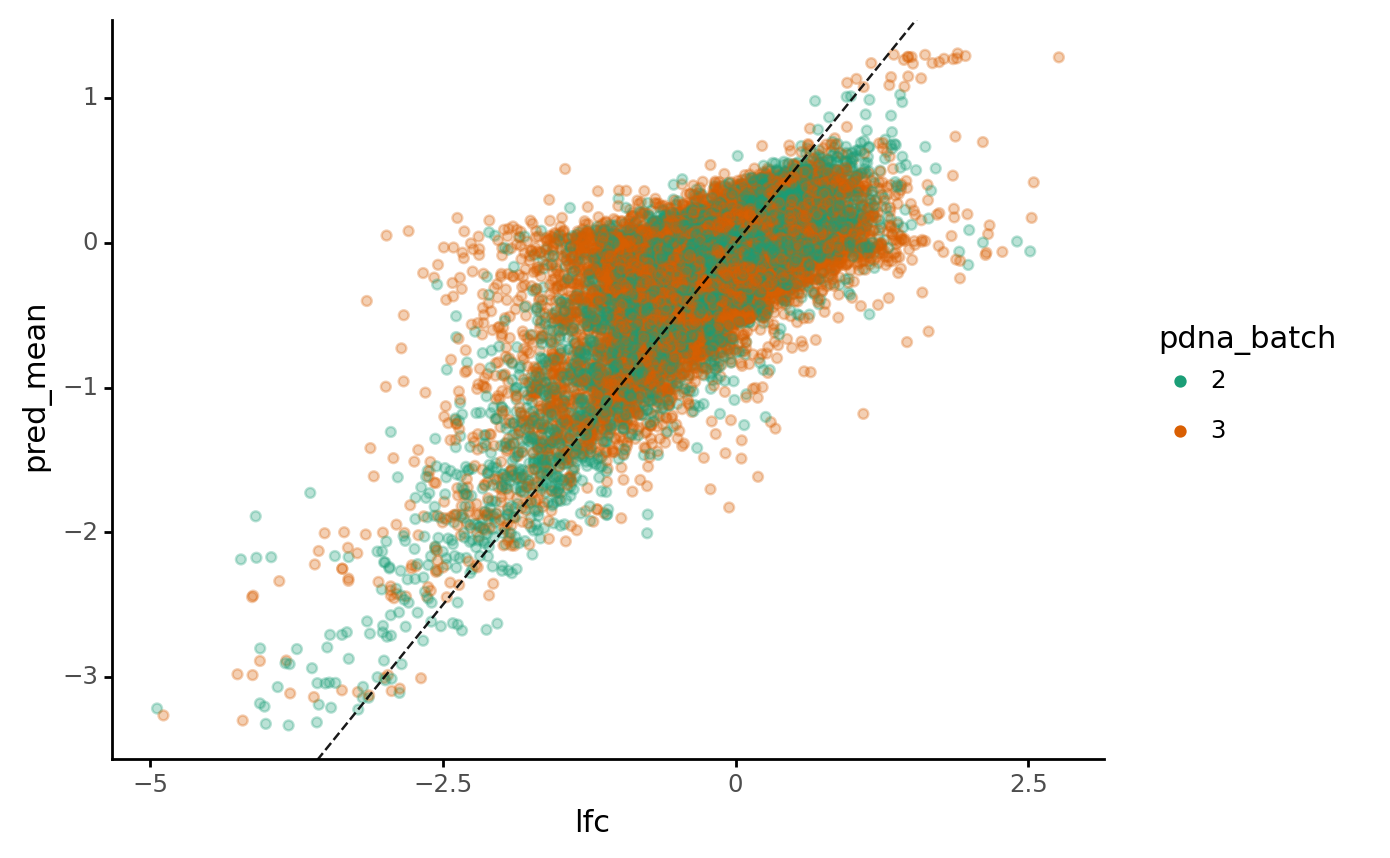

<ggplot: (358939920)>

In [87]:
(
    gg.ggplot(model_ppc, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_point(gg.aes(color="pdna_batch"), alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, alpha=0.9, linetype="--")
    + gg.scale_color_brewer(
        type="qual", palette="Dark2", guide=gg.guide_legend(override_aes={"alpha": 1})
    )
)

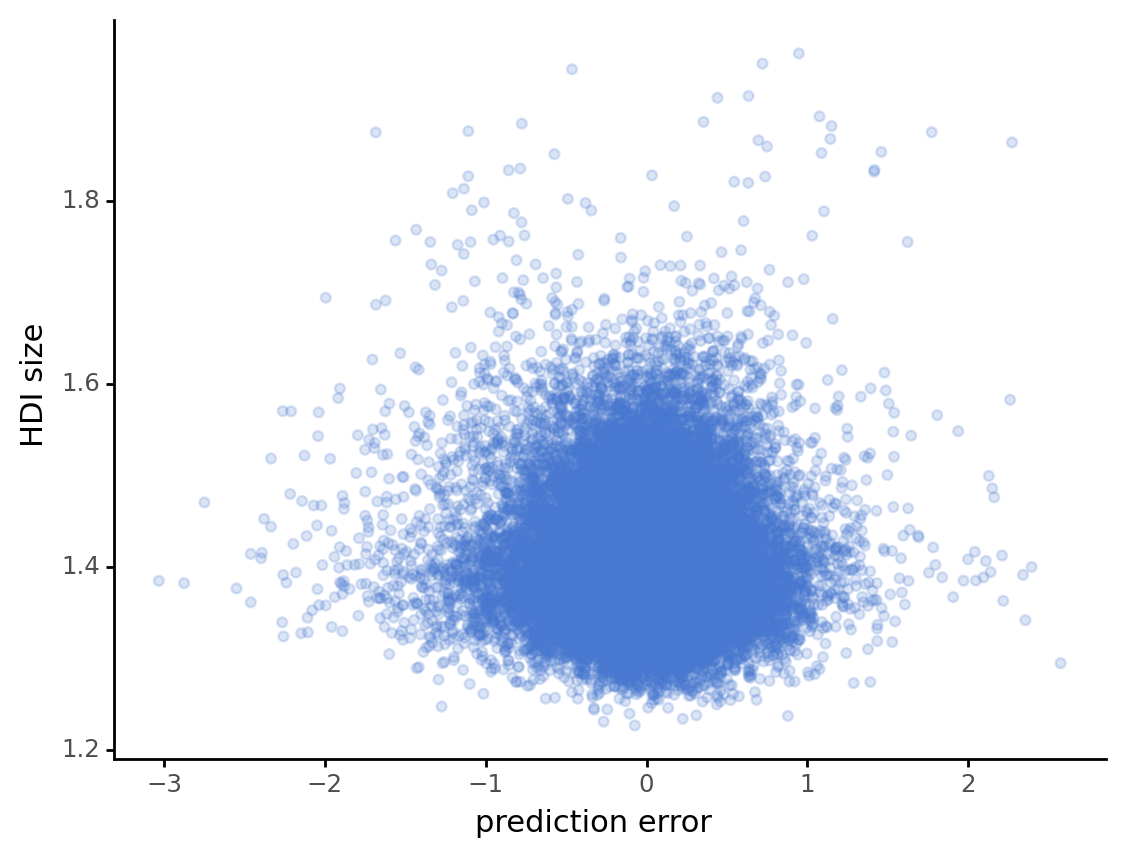

<ggplot: (369996891)>

In [88]:
(
    gg.ggplot(model_ppc, gg.aes(x="error", y="hdi_range"))
    + gg.geom_point(alpha=0.2, color=SeabornColor.blue)
    + gg.labs(x="prediction error", y="HDI size")
)

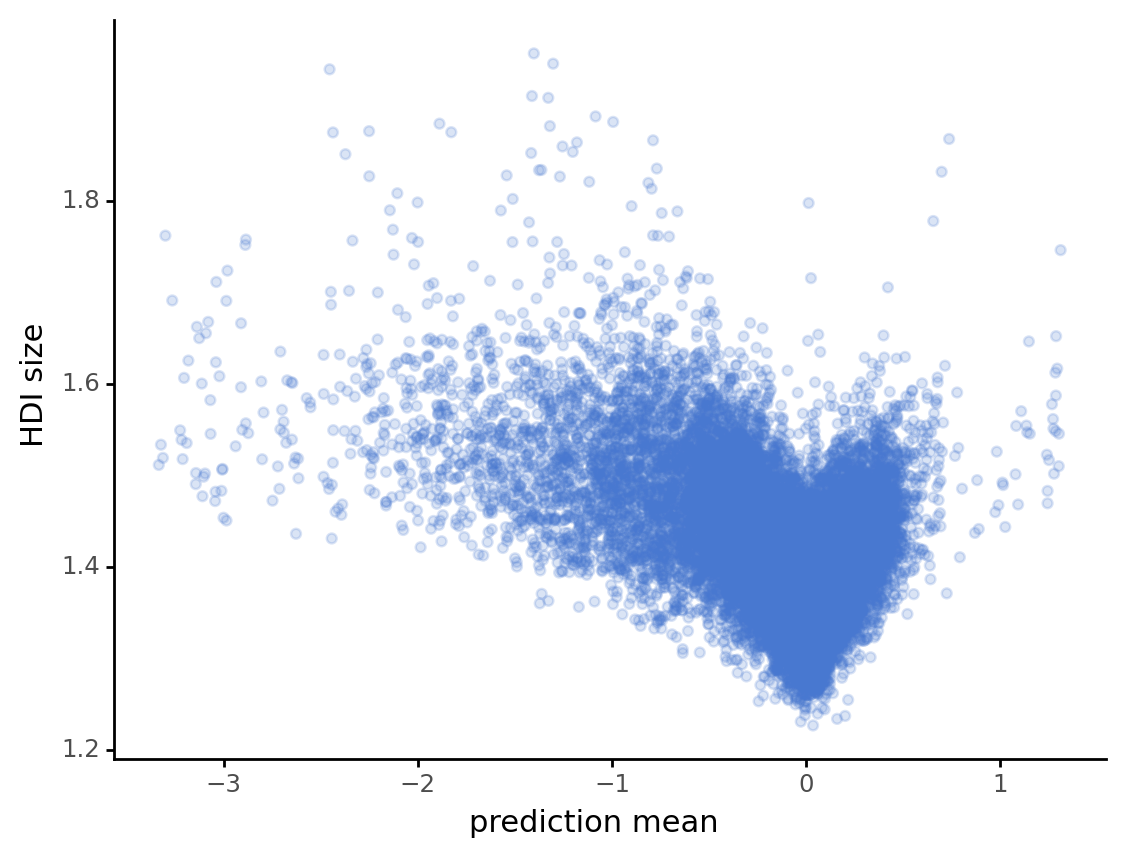

<ggplot: (369996930)>

In [89]:
(
    gg.ggplot(model_ppc, gg.aes(x="pred_mean", y="hdi_range"))
    + gg.geom_point(alpha=0.2, color=SeabornColor.blue)
    + gg.labs(x="prediction mean", y="HDI size")
)

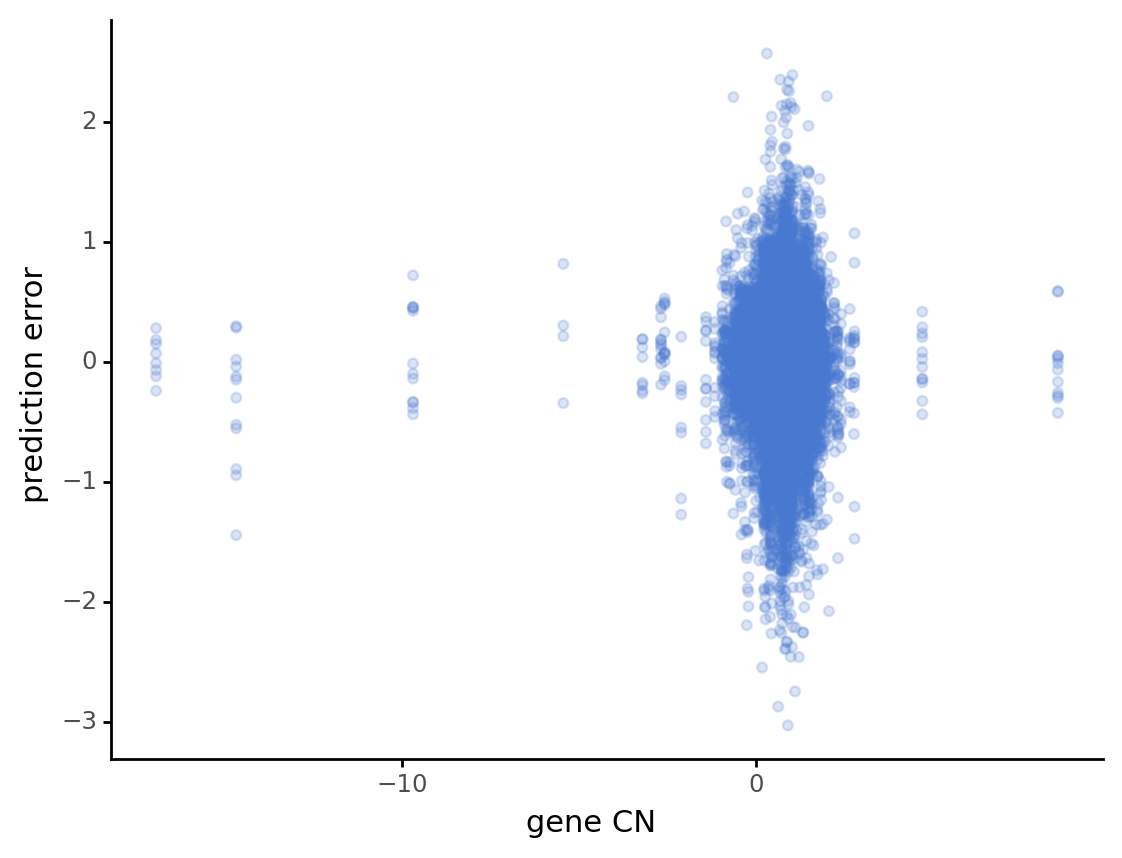

<ggplot: (369996813)>

In [90]:
(
    gg.ggplot(model_ppc, gg.aes(x="np.log2(gene_cn)", y="error"))
    + gg.geom_point(alpha=0.2, color=SeabornColor.blue)
    + gg.labs(x="gene CN", y="prediction error")
)

In [91]:
model_ppc_with_qpost = model_ppc.merge(
    sgrna_activity_post[["mean", "sgrna", "hugo_symbol"]].rename(
        columns={"mean": "q_post_mean"}
    )
)

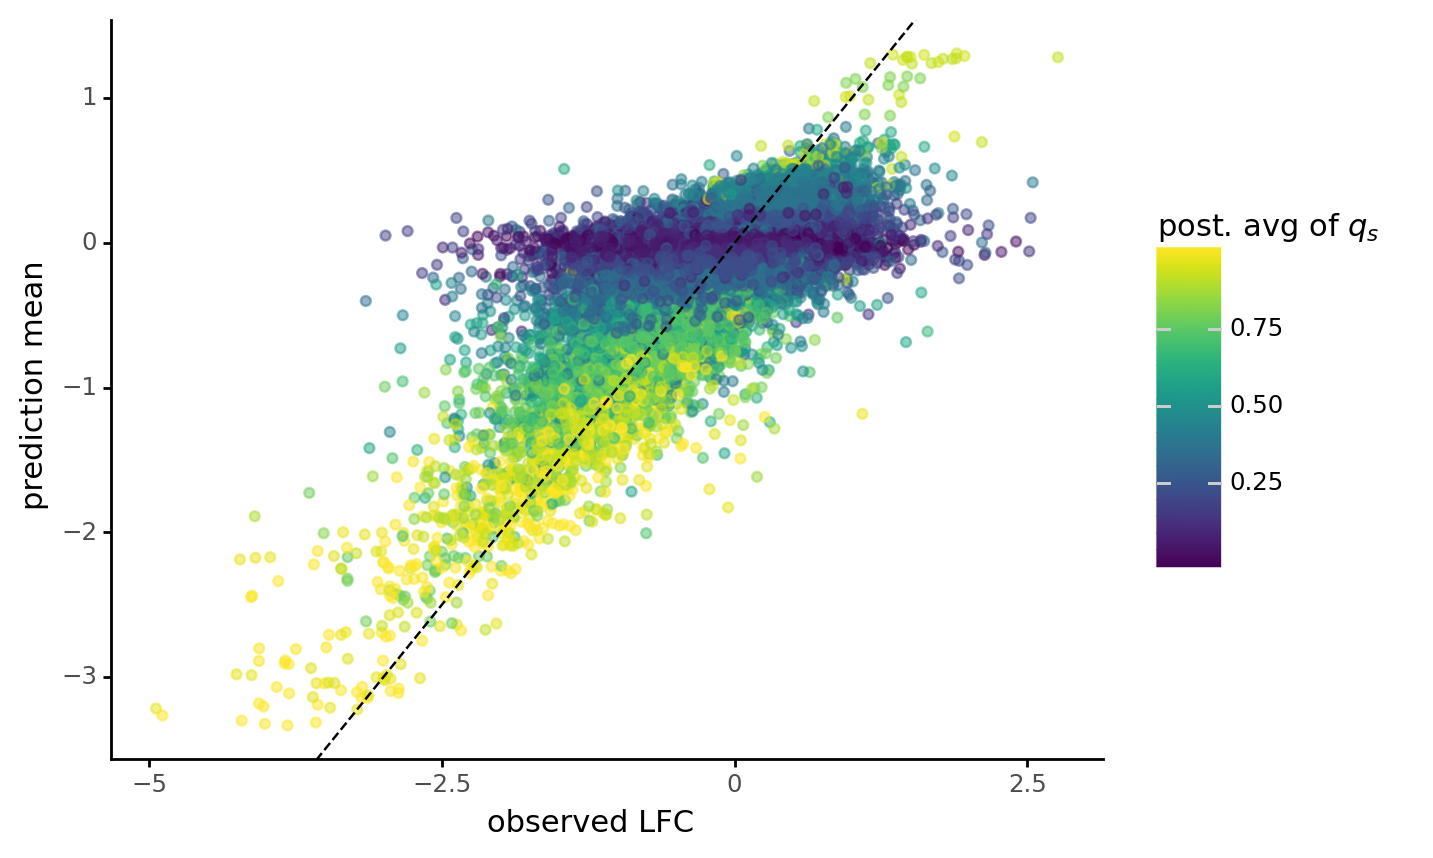

<ggplot: (370260128)>

In [92]:
(
    gg.ggplot(model_ppc_with_qpost, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_point(gg.aes(color="q_post_mean"), alpha=0.5)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.labs(
        x="observed LFC",
        y="posterior prediction mean",
        color="post. avg of $q_s$",
    )
)

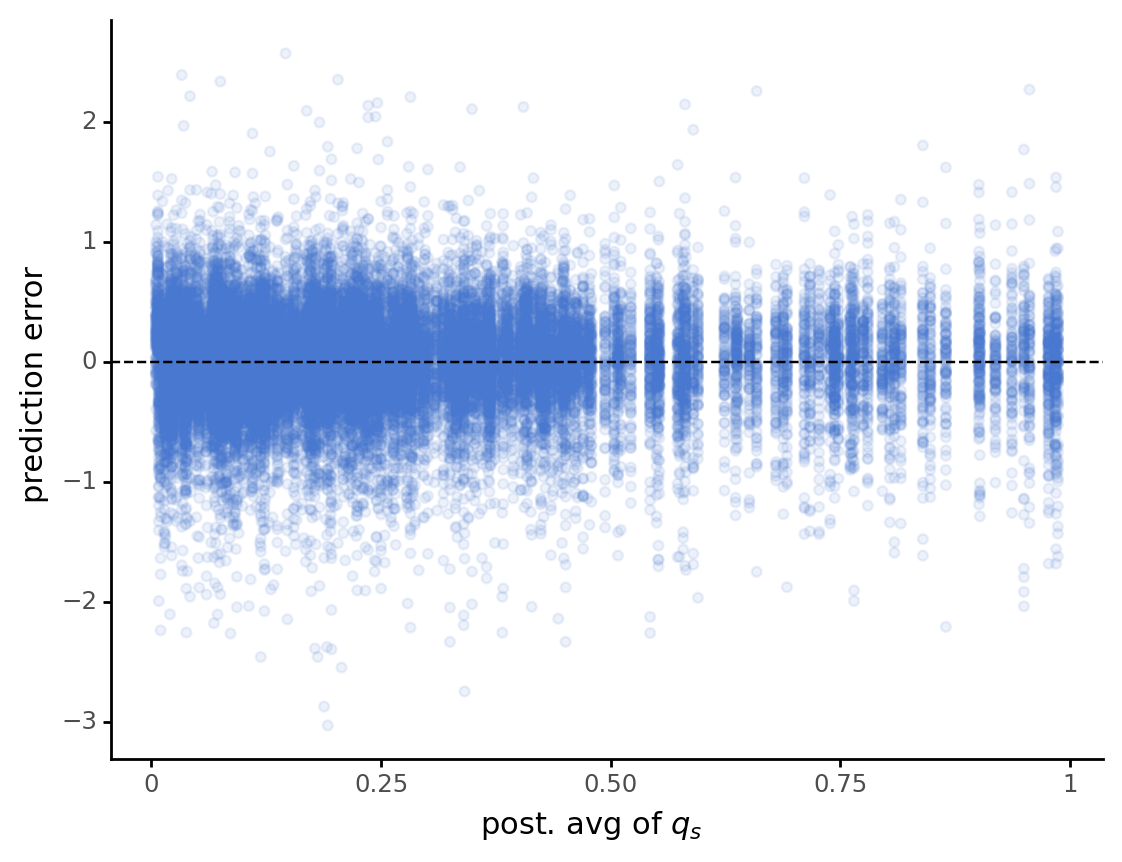

<ggplot: (369365794)>

In [93]:
(
    gg.ggplot(model_ppc_with_qpost, gg.aes(x="q_post_mean", y="error"))
    + gg.geom_point(alpha=0.1, color=SeabornColor.blue)
    + gg.geom_hline(yintercept=0, linetype="--")
    + gg.labs(x="post. avg of $q_s$", y="prediction error")
)

## Build by subclassing `CrcCeresMimicOne`

**Conclusion:** Doesn't work.

**Alternative solution:** Add to CrcCeresMimicOne as an *optional* parameter using an if-else block.

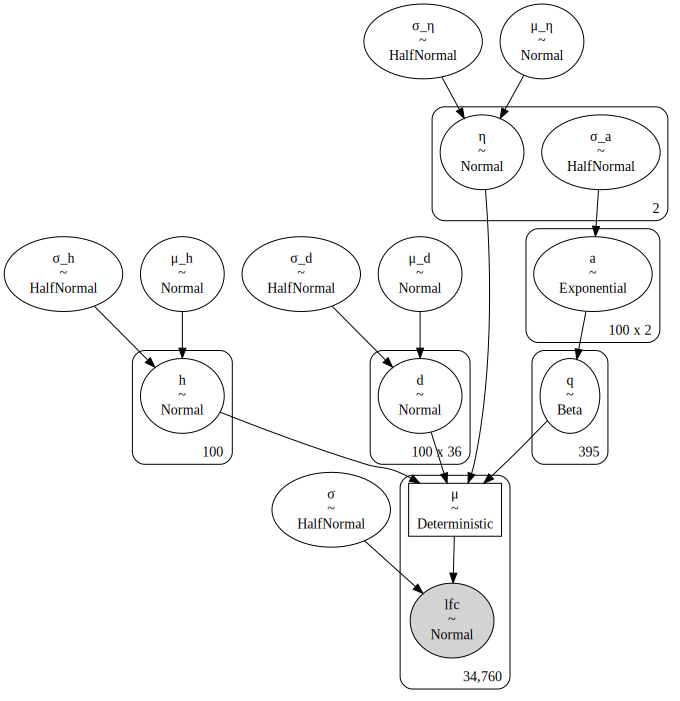

In [100]:
ceres_mimic = CrcCeresMimicOne(
    name="EXPT-BUILDING-MODEL", root_cache_dir=Path("temp/"), debug=True
)
ceres_mimic.build_model()
pm.model_to_graphviz(ceres_mimic.model)

In [101]:
copynumber_data = data.z_log2_cn.values
copynumber_shared = theano.shared(copynumber_data)
cellline_idx = indices.cellline_idx
cellline_idx_shared = theano.shared(cellline_idx)

with ceres_mimic.model:
    μ_β = pm.Normal("μ_β", 0, 0.1)
    σ_β = pm.HalfNormal("σ_β", 0.5)
    β = pm.Normal("β", μ_β, σ_β, shape=n_celllines)

    μ = μ + β[cellline_idx_shared] * copynumber_shared

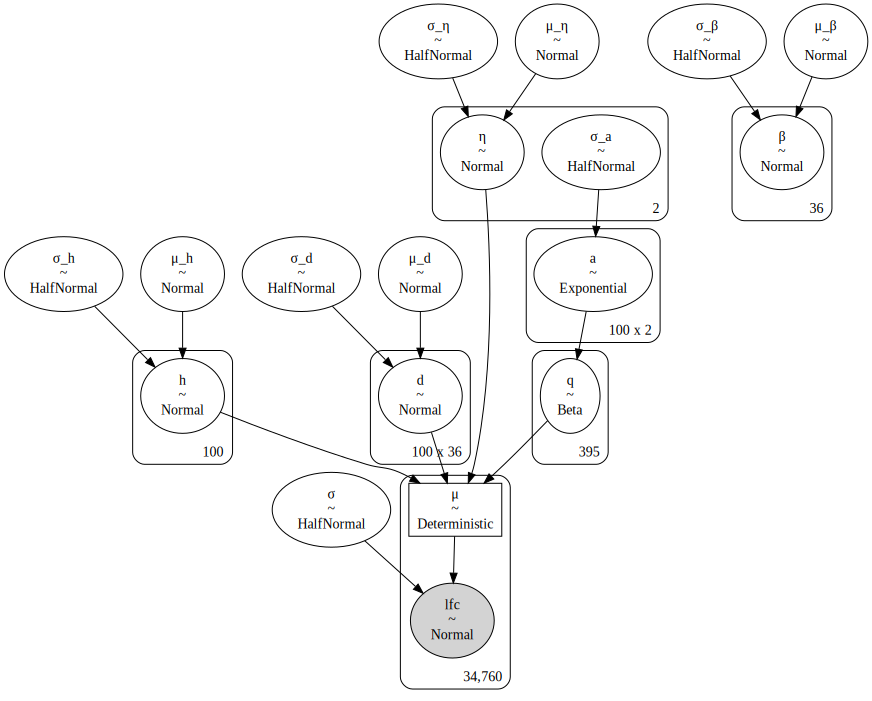

In [102]:
pm.model_to_graphviz(ceres_mimic.model)

---

In [33]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.79 minutes


In [34]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-29

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: ceres-mimic

theano    : 1.0.5
plotnine  : 0.7.1
pymc3     : 3.11.1
pandas    : 1.2.3
arviz     : 0.11.2
seaborn   : 0.11.1
numpy     : 1.20.1
re        : 2.2.1
matplotlib: 3.3.4

